#DATASCI W261, Machine Learning at Scale
--------
####Assignement:  week \#5
####[Lei Yang](mailto:leiyang@berkeley.edu) | [Michael Kennedy](mailto:mkennedy@ischool.berkeley.edu) | [Natarajan Krishnaswami](mailto:natarajan@krishnaswami.org)
####Due: 2016-02-18, 8AM PST

###*HW 5.0.* Q&A

####What is a data warehouse? What is a Star schema? When is it used?


###*HW 5.1* Q&A
####In the database world What is 3NF? Does machine learning use data in 3NF? If so why? 

####In what form does ML consume data?

####Why would one use log files that are denormalized?

###*HW 5.2*
Using MRJob, implement a hashside join (memory-backed map-side) for left, 
right and inner joins. Run your code on the data used in HW 4.4: (Recall HW 4.4: Find the most frequent visitor of each page using mrjob and the output of 4.2  (i.e., transfromed log file). In this output please include the webpage URL, webpageID and Visitor ID.):

Justify which table you chose as the Left table in this hashside join.

Please report the number of rows resulting from:

1. Left joining Table Left with Table Right
2. Right joining Table Left with Table Right
3. Inner joining Table Left with Table Right

###Solution
- set A-records as Left table which is stored in memory, because it has fewer data
- C- and V-lines are Right table, as the records streaming through, join visitor, page, and URL 
- emit (page_id, visitor_id)~URL

In [47]:
%%writefile HW5_2_JoinTable.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class JoinTable(MRJob):
    
    def mapper_init(self):
        self.left = {}
        self.right = []
        self.vistor = None
        
    # stream through lines, yield char count
    def mapper_inner(self, _, line):
        # get page id
        line = line.strip()
        # A-line
        if line[0] == 'A':
            d1, p_id, d2, p_name, url = line.split(',')
            self.left[p_id] = [p_name, url]
            return
        # C-line
        if line[0] == 'C':
            d1, d2, v_id = line.split(',')
            self.vistor = 'C_' + v_id
            return
        # V-line
        if line[0] == 'V':
            d1, p_id, d2 = line.split(',')
        else:
            return
        
        # inner join
        if p_id not in self.left:
            return
        else:        
            self.right.append(p_id)
            yield (p_id,self.vistor), self.left[p_id][1]
            
    def mapper_right(self, _, line):
        # get page id
        line = line.strip()
        # A-line
        if line[0] == 'A':
            d1, p_id, d2, p_name, url = line.split(',')
            self.left[p_id] = [p_name, url]
            return
        # C-line
        if line[0] == 'C':
            d1, d2, v_id = line.split(',')
            self.vistor = 'C_' + v_id
            return
        # V-line
        if line[0] == 'V':
            d1, p_id, d2 = line.split(',')
        else:
            return
        
        # right join
        if p_id not in self.left:
            yield (p_id, self.vistor), None
        else:            
            yield (p_id, self.vistor), self.left[p_id][1]
            
    def mapper_left(self, _, line):
        # get page id
        line = line.strip()
        # A-line
        if line[0] == 'A':
            d1, p_id, d2, p_name, url = line.split(',')
            self.left[p_id] = [p_name, url]
            return
        # C-line
        if line[0] == 'C':
            d1, d2, v_id = line.split(',')
            self.vistor = 'C_' + v_id
            return
        # V-line
        if line[0] == 'V':
            d1, p_id, d2 = line.split(',')
        else:
            return
        
        # right join
        if p_id in self.left:                        
            yield (p_id, self.vistor), self.left[p_id][1]
        elif p_id not in self.right:
            self.right.append(p_id)
    
    # left join only, yield left which right doesn't have
    def mapper_final(self):
        for p_id in self.right:
            yield (p_id, None), self.left[p_id][1]
        

    def reducer_init(self):
        self.n_row = 0
        
    def reducer(self, page, url):        
        self.n_row += 1
        
    def reducer_final(self):
        yield None, str(self.n_row)

    def steps(self):
        jobconf = {
            'mapreduce.job.maps': '3',
            'mapreduce.job.reduces': '1',
        }

        return [MRStep(mapper_init=self.mapper_init
                       # inner join
                       #,mapper=self.mapper_inner
                       # right join
                       #,mapper=self.mapper_right
                       # left join
                       ,mapper=self.mapper_left, mapper_final=self.mapper_final
                       # reducer
                       ,reducer_init=self.reducer_init, reducer=self.reducer, reducer_final=self.reducer_final
                       ,jobconf=jobconf
                       )                
               ]


if __name__ == '__main__':
    JoinTable.run()



Overwriting HW5_2_JoinTable.py


###Execute MrJob
- inner: 98654
- left: 98654
- right: 98654

In [48]:
##### run it locally via python #####
!python HW5_2_JoinTable.py anonymous-msweb.data > debug

##### run it locally on hadoop #####
#!python HW5_2_JoinTable.py anonymous-msweb.data -r hadoop > debug
#!cat debug


using configs in /Users/leiyang/.mrjob.conf
creating tmp directory /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/HW5_2_JoinTable.leiyang.20160217.051020.033484

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

writing to /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/HW5_2_JoinTable.leiyang.20160217.051020.033484/step-0-mapper_part-00000
Counters from step 1:
  (no counters found)
writing to /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/HW5_2_JoinTable.leiyang.20160217.051020.033484/step-0-mapper-sorted
> sort /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/HW5_2_JoinTable.leiyang.20160217.051020.033484/step-0-mapper_part-00000
writing to /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/HW5_2_JoinTable.leiyang.20160217.051020.033484/step-0-reducer_part-00000
Counters from step 1:
  (n

###*HW 5.3* For the remainder of this assignment you will work with two datasets:

#### 1: unit/systems test data set: SYSTEMS TEST DATASET
Three terms, A,B,C and their corresponding strip-docs of co-occurring terms

- DocA {X:20, Y:30, Z:5}
- DocB {X:100, Y:20}
- DocC {M:5, N:20, Z:5}


#### 2: A large subset of the Google n-grams dataset

https://aws.amazon.com/datasets/google-books-ngrams/

which we have placed in a bucket/folder on Dropbox on s3:

   https://www.dropbox.com/sh/tmqpc4o0xswhkvz/AACUifrl6wrMrlK6a3X3lZ9Ea?dl=0 

   s3://filtered-5grams/

For each HW 5.3 -5.5 Please unit test and system test your code with with SYSTEMS TEST DATASET and show the results. 
Please compute the expected answer by hand and show your hand calculations. Then show the results you get with you system.
Final show your results on the Google n-grams dataset


In particular, this bucket contains (~200) files (10Meg each) in the format:

- 	(ngram) \t (count) \t (pages_count) \t (books_count)
- e.g. 'A Case Study of Limited	55	55	43'

Do some EDA on this dataset using mrjob, e.g., 

- Longest 5-gram (number of characters)
- Top 10 most frequent words (count), i.e., unigrams
- Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency (Hint: save to PART-000* and take the head -n 1000)
- Distribution of 5-gram sizes (counts) sorted in decreasing order of relative frequency. (Hint: save to PART-000* and take the head -n 1000)
OPTIONAL Question:
- Plot the log-log plot of the frequency distributuion of unigrams. Does it follow power law distribution?

For more background see:
- https://en.wikipedia.org/wiki/Log%E2%80%93log_plot
- https://en.wikipedia.org/wiki/Power_law


###HW5.3 - The longest 5-gram

In [119]:
%%writefile HW5_3_Longest5Gram.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class Longest5Gram(MRJob):

    # stream through lines, yield char count
    def mapper(self, _, line):
        # get page id
        n_gram, cnt, p_cnt, b_cnt = line.strip().split('\t')
        yield n_gram, len(n_gram)
        

    def reducer_init(self):
        self.length = 0
        self.longest = None

    def reducer(self, n_gram, n_char):
        cnt = sum(n_char)
        if cnt > self.length:
            self.longest = n_gram
            self.length = cnt

    def reducer_final(self):
        yield self.longest, (self.length)

    def steps(self):
        jobconf = {
            'mapreduce.job.maps': '30',
            'mapreduce.job.reduces': '1',
        }

        return [MRStep(mapper=self.mapper
                       # NOTE: combiner doesn't work on EMR Hadoop-1.0.3 & AMI-2.4.2, 
                       # only on AMI-3.11.0 with Hadoop-2.4.0
                       ,combiner_init=self.reducer_init 
                       ,combiner=self.reducer
                       ,combiner_final=self.reducer_final
                       ,reducer_init=self.reducer_init
                       ,reducer=self.reducer
                       ,reducer_final=self.reducer_final
                       ,jobconf=jobconf
                       )                
               ]


if __name__ == '__main__':
    Longest5Gram.run()


Overwriting HW5_3_Longest5Gram.py


###Execute MrJob

- with EMR running for s3://filtered-5grams/, the longest 5-gram is:
- **"AIOPJUMRXUYVASLYHYPSIBEMAPODIKR UFRYDIUUOLBIGASUAURUSREXLISNAYE RNOONDQSRUNSUBUNOUGRABBERYAIRTC UTAHRAPTOREDILEIPMILBDUMMYUVERI SYEVRAHVELOCYALLOSAURUSLINROTSR"	**
- number of character: 159


In [101]:
##### run it locally via python #####
#!python HW5_3_Longest5Gram.py ngram_test.txt > debug

##### run it locally on hadoop #####
#!python HW5_3_Longest5Gram.py ngram_test.txt -r hadoop > debug
!python HW5_3_Longest5Gram.py googlebooks-eng-all-5gram-20090715-0-filtered.txt -r hadoop > debug
!cat debug

##### run it on emr #####
#!python HW5_3_Longest5Gram.py s3://filtered-5grams/ -r emr --output-dir 's3://us-west-2/w261.data/HW5/'  --no-output

#!python HW5_3_Longest5Gram.py googlebooks-eng-all-5gram-20090715-0-filtered.txt -r emr --output-dir 's3://us-west-2/w261.data/HW5/'  --no-output


using configs in /Users/leiyang/.mrjob.conf
creating tmp directory /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/HW5_3_Longest5Gram.leiyang.20160214.215417.539788
writing wrapper script to /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/HW5_3_Longest5Gram.leiyang.20160214.215417.539788/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/leiyang/tmp/mrjob/HW5_3_Longest5Gram.leiyang.20160214.215417.539788/files/

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

HADOOP: packageJobJar: [/var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/hadoop-unjar8609884381448338019/] [] /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/streamjob1002621193370530292.jar tmpDir=null
Counters from step 1:
  (no counters found)
Streaming final output from hdfs:///user/leiyang/tmp/mrjob

###HW5.3 - Top 10 most frequent words (count), i.e., unigrams

In [44]:
%%writefile HW5_3_Top10Words.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class Top10Words(MRJob):

    # stream through lines, yield word count
    def mapper(self, _, line):
        # get page id
        n_gram, cnt, p_cnt, b_cnt = line.strip().split('\t')
        cnt = int(cnt)
        for w in n_gram.lower().split(' '):
            yield w, cnt

    # sum word counts, use as combiner too
    def reducer(self, word, count):
        yield word, sum(count)
        
    # job to sort the results ###########################
    def mapper_sort1(self, word, count):
        yield (word, count), None
        
    def reducer_sort_init1(self):
        self.top = 20
        self.n = 0
        
    def reducer_sort1(self, results, dummy):        
        if self.n < self.top:
            self.n += 1
            yield results

    def steps(self):
        jobconf1 = {  #key value pairs 
            'mapreduce.job.maps': '3',
            'mapreduce.job.reduces': '3',
        }
        
        jobconf2 = {  #key value pairs            
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options': '-k2,2nr',
            'mapreduce.job.maps': '2',
            'mapreduce.job.reduces': '1',
            'stream.num.map.output.key.fields': '2',
            'mapreduce.map.output.key.field.separator': ' ',
            'stream.map.output.field.separator': ' ',            
        }

        return [MRStep(mapper=self.mapper                       
                       ,combiner=self.reducer                                              
                       ,reducer=self.reducer                       
                       ,jobconf=jobconf1
                       )
                ,MRStep(mapper=self.mapper_sort1
                       ,reducer_init=self.reducer_sort_init1
                       ,reducer=self.reducer_sort1
                       ,jobconf=jobconf2
                       )
               ]


if __name__ == '__main__':
    Top10Words.run()



Overwriting HW5_3_Top10Words.py


###Execute MrJob
- **with EMR running for s3://filtered-5grams/, the top 10 words are:**
 
 
| Word        | Count           |
| ------------- |:-------------:| 
| "the"      | 5490815394 | 
| "of"      | 3698583299      | 
| "to" |  2227866570    | 
| "in" |	1421312776 |
| "a" |	1361123022 |
| "and" |	1149577477 |
| "that" |	802921147 |
| "is" |	758328796 |
| "be" |	688707130 |
| "as" |	492170314 |

In [45]:
##### run it locally via python #####
#!python HW5_3_Top10Words.py ngram_test.txt > debug2

##### run it locally on hadoop with a sample file #####
#!python HW5_3_Top10Words.py ngram_test.txt -r hadoop > debug38
!python HW5_3_Top10Words.py ngram_test.txt -r hadoop
#!cat debug

##### run it on emr #####
#!python HW5_3_Top10Words.py s3://filtered-5grams/ -r emr --cleanup=NONE  --no-output
#!python HW5_3_Top10Words.py ngram_test.txt -r emr --cleanup=NONE  --no-output


using configs in /Users/leiyang/.mrjob.conf
creating tmp directory /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/HW5_3_Top10Words.leiyang.20160216.005540.666756
writing wrapper script to /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/HW5_3_Top10Words.leiyang.20160216.005540.666756/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/leiyang/tmp/mrjob/HW5_3_Top10Words.leiyang.20160216.005540.666756/files/

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

HADOOP: packageJobJar: [/var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/hadoop-unjar969921165491504766/] [] /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/streamjob6150646407912706716.jar tmpDir=null
Counters from step 1:
  (no counters found)
HADOOP: packageJobJar: [/var/folders/tx/5ldq67q511q8wqwqkvptnxd00

###HW5.3 - Most/Least densely appearing words (count/pages_count) sorted in decreasing order of relative frequency 
- Hint: save to PART-000\* and take the head -n 1000
- every word appears at least once per page, so the least densely appearing ratio is $1$, and there are a bunch of those
- we do reverse sorting below for $\frac{count}{pages\_count}$, and show the top 200.

Top 10 most densely appearing words:

| word | count/Page_count |
| ------------- |:-------------:|
|"xxxx" |	11.557291666666666 |
|"blah"	| 8.0741599073001158 |
|"nnn"	| 7.5333333333333332 |
|"na"	| 6.2017491314244637 |
|"oooooooooooooooo"	| 4.921875 |
|"nd"	| 4.8543057272352703 |
|"llll"	| 4.5116279069767442 |
|"oooooo" |	4.169650013358269 |
|"ooooo" |	3.8586371934672128 |
|"lillelu" |	3.7624521072796937 |



In [216]:
%%writefile HW5_3_MostLeastDenseWords.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class MostLeastDenseWords(MRJob):

    # stream through lines, yield word count
    def mapper(self, _, line):
        # get page id
        n_gram, cnt, p_cnt, b_cnt = line.strip().split('\t')
        cnt, p_cnt = int(cnt), int(p_cnt)
        for w in n_gram.lower().split(' '):
            yield w, (cnt, p_cnt)
            
    # combiner
    def combiner(self, word, counts):
        cnt = p_cnt = 0
        for c in counts:
            cnt += c[0]
            p_cnt += c[1]
        yield word, (cnt, p_cnt)
   
    # sum word counts, use as combiner too
    def reducer(self, word, counts):
        cnt = p_cnt = 0
        for c in counts:
            cnt += c[0]
            p_cnt += c[1]
        yield word, 1.0*cnt/p_cnt
        
    # job to sort the results ###########################
    def mapper_sort1(self, word, ratio):
        yield (word, ratio), None
        
    def reducer_sort_init1(self):
        self.top = 200
        self.n = 0
        
    def reducer_sort1(self, results, dummy):        
        if self.n < self.top:
            self.n += 1
            yield results

    def steps(self):
        jobconf1 = {  #key value pairs 
            'mapreduce.job.maps': '3',
            'mapreduce.job.reduces': '3',
        }
        
        jobconf2 = {  #key value pairs            
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options': '-k2,2nr -k1,1',
            'mapreduce.job.maps': '2',
            'mapreduce.job.reduces': '1',
            'stream.num.map.output.key.fields': '2',
            'mapreduce.map.output.key.field.separator': ' ',
            'stream.map.output.field.separator': ' ',            
        }

        return [MRStep(mapper=self.mapper                       
                       ,combiner=self.combiner
                       ,reducer=self.reducer                       
                       ,jobconf=jobconf1
                       )
                ,MRStep(mapper=self.mapper_sort1
                       ,reducer_init=self.reducer_sort_init1
                       ,reducer=self.reducer_sort1
                       ,jobconf=jobconf2
                       )
               ]


if __name__ == '__main__':
    MostLeastDenseWords.run()



Overwriting HW5_3_MostLeastDenseWords.py


###Execute MrJob job

In [217]:
##### run it locally via python #####
#!python HW5_3_MostLeastDenseWords.py ngram_test.txt > debug

##### run it locally on hadoop with a sample file #####
!python HW5_3_MostLeastDenseWords.py ngram_test.txt -r hadoop > debug
!head -20 debug

##### run it on emr #####
#!python HW5_3_MostLeastDenseWords.py s3://filtered-5grams/ -r emr --cleanup=NONE  --no-output
#!python HW5_3_MostLeastDenseWords.py ngram_test.txt -r emr --cleanup=NONE  --no-output


using configs in /Users/leiyang/.mrjob.conf
creating tmp directory /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/HW5_3_MostLeastDenseWords.leiyang.20160215.041741.560658
writing wrapper script to /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/HW5_3_MostLeastDenseWords.leiyang.20160215.041741.560658/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/leiyang/tmp/mrjob/HW5_3_MostLeastDenseWords.leiyang.20160215.041741.560658/files/

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

HADOOP: packageJobJar: [/var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/hadoop-unjar6935029832103145630/] [] /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/streamjob9152720224773007202.jar tmpDir=null
Counters from step 1:
  (no counters found)
HADOOP: packageJobJar: [/var/folders/

###HW5.3 - Distribution of 5-gram sizes (character length).  
- E.g., count (using the count field) up how many times a 5-gram of 50 characters shows up. 
- Plot the data graphically using a histogram.


In [104]:
%%writefile HW5_3_Distribution5Gram.py
from mrjob.job import MRJob
from mrjob.step import MRStep

class Distribution5Gram(MRJob):

    # stream through lines, yield word count
    def mapper(self, _, line):
        # get counts
        n_gram, cnt, p_cnt, b_cnt = line.strip().split('\t')        
        yield len(n_gram), int(cnt)
            
    # combiner/reducer
    def combiner(self, n_gram, count):        
        yield n_gram, sum(count)
        
    # job to sort the results ###########################
    def mapper_sort1(self, word, ratio):
        yield (word, ratio), None
        
    def reducer_sort1(self, results, dummy):               
        yield results

    def steps(self):
        jobconf1 = {  #key value pairs 
            'mapreduce.job.maps': '3',
            'mapreduce.job.reduces': '1',
        }
        
        jobconf2 = {  #key value pairs            
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options': '-k2,2nr',
            'mapreduce.job.maps': '4',
            'mapreduce.job.reduces': '1',
            'stream.num.map.output.key.fields': '2',
            'mapreduce.map.output.key.field.separator': ' ',
            'stream.map.output.field.separator': ' ',            
        }

        return [MRStep(mapper=self.mapper                       
                       ,combiner=self.combiner                       
                       ,reducer=self.combiner           
                       ,jobconf=jobconf1
                       )
                ,MRStep(mapper=self.mapper_sort1                
                       ,reducer=self.reducer_sort1
                       ,jobconf=jobconf2
                       )
               ]


if __name__ == '__main__':
    Distribution5Gram.run()



Overwriting HW5_3_Distribution5Gram.py


###Execute MrJob

In [105]:
##### run it locally via python #####
#!python HW5_3_Distribution5Gram.py ngram_test.txt > debug

##### run it locally on hadoop with a sample file #####
!python HW5_3_Distribution5Gram.py ngram_test.txt -r hadoop > debug
#!head -20 debug

##### run it on emr #####
#!python HW5_3_Distribution5Gram.py s3://filtered-5grams/ -r emr --cleanup=NONE  --no-output


using configs in /Users/leiyang/.mrjob.conf
creating tmp directory /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/HW5_3_Distribution5Gram.leiyang.20160216.032520.071600
writing wrapper script to /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/HW5_3_Distribution5Gram.leiyang.20160216.032520.071600/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/leiyang/tmp/mrjob/HW5_3_Distribution5Gram.leiyang.20160216.032520.071600/files/

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

HADOOP: packageJobJar: [/var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/hadoop-unjar562392759491923876/] [] /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/streamjob2542307027320679323.jar tmpDir=null
Counters from step 1:
  (no counters found)
HADOOP: packageJobJar: [/var/folders/tx/5ldq

###Plot 5-gram Size Distribution

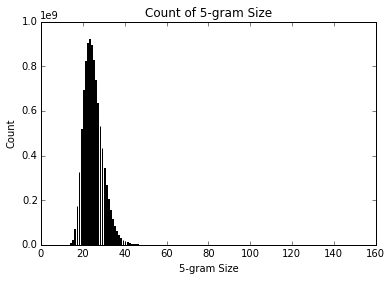

In [127]:
%matplotlib inline
import matplotlib.pyplot as plt
from numpy import loadtxt

mat = loadtxt('Dist5Gram')
plt.bar(mat[:,0],mat[:,1],0.4)

plt.ylabel('Count')
plt.xlabel('5-gram Size')
plt.title('Count of 5-gram Size')
plt.show()

###HW5.3 - *OPTIONAL* Plot the log-log plot of the frequency distributuion of unigrams. Does it follow power law distribution?

###Write SYSTEMS_TEST_DATASET.txt

In [420]:
%%writefile SYSTEMS_TEST_DATASET.txt
DocA {'X':20, 'Y':30, 'Z':5}
DocB {'X':100, 'Y':20}
DocC {'M':5, 'N':20, 'Z':5}

Overwriting SYSTEMS_TEST_DATASET.txt


###Paper-and-Pencil Solution

###*HW 5.4 * (over 2Gig of Data)
In this part of the assignment we will focus on developing methods
for detecting synonyms, using the Google 5-grams dataset. To accomplish
this you must script two main tasks using MRJob:

1. Build stripes of word co-ocurrence for the top 10,000 using the words ranked from 9001,-10,000 as a basis
most frequently appearing words across the entire set of 5-grams,
and output to a file in your bucket on s3 (bigram analysis, though the words are non-contiguous).

2. Using two (symmetric) comparison methods of your choice 
(e.g., correlations, distances, similarities), pairwise compare 
all stripes (vectors), and output to a file in your bucket on s3.

**Design notes for (1)**
For this task you will be able to modify the pattern we used in HW 3.2
(feel free to use the solution as reference). To total the word counts 
across the 5-grams, output the support from the mappers using the total 
order inversion pattern:

<*word,count>

to ensure that the support arrives before the cooccurrences.

In addition to ensuring the determination of the total word counts,
the mapper must also output co-occurrence counts for the pairs of
words inside of each 5-gram. Treat these words as a basket,
as we have in HW 3, but count all stripes or pairs in both orders,
i.e., count both orderings: (word1,word2), and (word2,word1), to preserve
symmetry in our output for (2).

**Design notes for (2)**
For this task you will have to determine a method of comparison.
Here are a few that you might consider:

- Jaccard
- Cosine similarity
- Spearman correlation
- Euclidean distance
- Taxicab (Manhattan) distance
- Shortest path graph distance (a graph, because our data is symmetric!)
- Pearson correlation
- Kendall correlation
- ...

However, be cautioned that some comparison methods are more difficult to
parallelize than others, and do not perform more associations than is necessary, 
since your choice of association will be symmetric.

Please use the inverted index (discussed in live session #5) based pattern to compute the pairwise (term-by-term) similarity matrix. 


###HW5.4 - MRJob to get the top 10,000 words
- only output 1,001 ~ 10,000 on the top 10,000 list

In [65]:
%%writefile HW5_4_Get10kWords.py

from mrjob.job import MRJob
from mrjob.step import MRStep

class Get10kWords(MRJob):

    # stream through lines, yield word count
    def mapper(self, _, line):
        # get page id
        n_gram, cnt, p_cnt, b_cnt = line.strip().split('\t')
        cnt = int(cnt)
        for w in n_gram.lower().split(' '):
            yield w, cnt

    # sum word counts, use as combiner too
    def reducer(self, word, count):
        yield word, sum(count)

    # job to sort the results ###########################
    def mapper_sort1(self, word, count):
        yield (word, count), None

    def reducer_sort_init1(self):
        self.cut = 1000
        self.total = 10000
        self.n = 0

    def reducer_sort1(self, results, dummy):
        self.n += 1
        if self.n > self.cut and self.n <= self.total:            
            yield results

    def steps(self):
        jobconf1 = {  #key value pairs
            'mapreduce.job.maps': '20',
            'mapreduce.job.reduces': '20',
        }

        jobconf2 = {  #key value pairs
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options': '-k2,2nr',
            'mapreduce.job.maps': '15',
            'mapreduce.job.reduces': '1',
            'stream.num.map.output.key.fields': '2',
            'mapreduce.map.output.key.field.separator': ' ',
            'stream.map.output.field.separator': ' ',
        }

        return [MRStep(mapper=self.mapper
                       ,combiner=self.reducer
                       ,reducer=self.reducer
                       ,jobconf=jobconf1
                       )
                ,MRStep(mapper=self.mapper_sort1
                       ,reducer_init=self.reducer_sort_init1
                       ,reducer=self.reducer_sort1
                       ,jobconf=jobconf2
                       )
               ]


if __name__ == '__main__':
    Get10kWords.run()


Overwriting HW5_4_Get10kWords.py


###Execute MrJob
- top 10,000 words, except from 1 - 1000, from the corpus are [here]()

In [64]:
##### run it locally via python #####
#!python HW5_4_Get10kWords.py ngram_test.txt > debug

##### run it locally on hadoop #####
!python HW5_4_Get10kWords.py ngram_test.txt -r hadoop > debug2

##### run it on emr #####
# s3 folder: s3://aws-logs-149687825236-us-east-1/elasticmapreduce/

#!python HW5_4_Get10kWords.py ngram_test.txt -r emr --cleanup=NONE --no-output > debug

#!python HW5_4_Get10kWords.py s3://filtered-5grams/ -r emr --cleanup=NONE --no-output



using configs in /Users/leiyang/.mrjob.conf
creating tmp directory /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/HW5_4_Get10kWords.leiyang.20160216.010646.797154
writing wrapper script to /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/HW5_4_Get10kWords.leiyang.20160216.010646.797154/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/leiyang/tmp/mrjob/HW5_4_Get10kWords.leiyang.20160216.010646.797154/files/

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

HADOOP: packageJobJar: [/var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/hadoop-unjar471521431493938887/] [] /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/streamjob5993568477184740852.jar tmpDir=null
Counters from step 1:
  (no counters found)
HADOOP: packageJobJar: [/var/folders/tx/5ldq67q511q8wqwqkvptnx

###HW5.4 - MrJob for Jaccard/Cosine Similarity
- **Jaccard Similarity:** 
$$S_{A,B}=\frac{|A\cap B|}{|A\cup B|}=\frac{|A\cap B|}{|A|+|B|-|A\cap B|}$$


- **Job 0** - for n-gram input, build the pseudo-doc (co-ocurrence matrix/word stripes) first
  - **mapper**: emit *((w1,w2) ~ count)* for pair count
  - **reducer**: obtain co-ocurrence matrix
- **Job 1** - build inverted index for n-gram
  - **mapper**: emit *((term,n_gram_id/doc_id) ~ 1)* for each word in the n-gram. 
   - **Note**: since the test file and n-gram file have different format, we will create two mapper to data from each, but both emits should have identical format 
  - **combiner**: local aggregation of co-ocurrence
  - **partitioner**: -k1,1 -k2,2 apply secondary sorting
  - **reducer**: summary to build inverted index
- **NOTE**: for co-ocurrence matrix, the inverted indexing is its transpose, and because co-ocurrence is symmetric, inverted index is identical. Thus we can skip *Job 1* for synonym dection.
- **Job 2** - obtain pairwise similarity for words from n-gram
  - **mapper**: 
   - emit ((*,term) ~ 1) for each term in the inverted index, using order inversion to calculate $|A|$ and $|B|$
   - emit ((A,B) ~ payload) for each *sorted* pair in the inverted index, to get all components for $|A\cap B|$
  - **combiner**: local aggregation
  - **single reducer**: calcualte $S_{A,B}$, **or** use customized partitioner to have (*,word) available for all reducers.
   - **Note**: since $S_{A,B}$ requires both $|A|$ and $|B|$, which are also needed in evaluating similarity for any other pairs that have them, it's impossible to have both norm in a realtime fashion, thus we cache them in the reducer. Hopefully this is not entirely unrealistic given that the amount of single word is relatively small.
- **Job 3** - get top n similarities for synonym
  - **mapper**: emit *($S_{A,B}$ ~ (A,B))*
  - **partitioner**: -k1,1nr
  - **reducer**: print out first n paris

In [4]:
%%writefile HW5_4_Jaccard.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from math import sqrt
from subprocess import Popen, PIPE
 
class Jaccard(MRJob):
    
    PARTITIONER='org.apache.hadoop.mapred.lib.KeyFieldBasedPartitioner'
    
    #################################  job 0 - create co-occurrence matrix ##############################
    
    # job 0 mapper for SYSTEMS_TEST_DATASET
    def j0_mapper_read_test(self, _, line):        
        # time of mapper being called
        self.increment_counter('HW5_4', 'mapper_test', 1)
        # parse line, get doc id and terms
        word, strip = line.strip().split(' ', 1)
        cmd = 'strip = ' + strip
        exec cmd
        # emit co-occurrence matrix
        yield word, strip
            
    # job 0 mapper_init: load our 9k favorite words, and evaluate those only
    def j0_mapper_read_5gram_init(self):
        localPath = '/Users/leiyang/GitHub/mids/w261/HW5-Questions/Top10kWords'
        cat = Popen(["cat", 'Top10kWords'], stdout=PIPE)
        self.corpus = [s.split()[0].strip('"') for s in cat.stdout][:4500]
        
    # job 0 mapper for 5-gram: build pseudo-document (co-ocurrence matrix) & emit inverted index
    def j0_mapper_read_5gram(self, _, line):
        # parse line, get words and counts
        grams, cnt, p_cnt, b_cnt = line.strip().split('\t')
        # only keep words from the 9k corpus
        grams = grams.lower().split(' ')
        grams = [x for x in grams if x in self.corpus]
        n_gram = len(grams)
        # emit co-ocurrence for each pair (MUST include all pairs to have correct inverted index)
        for w1, w2 in [[grams[i], grams[j]] for i in range(n_gram) for j in range(n_gram)]:
            yield (w1, w2), int(cnt)
                        
    # job 0 combiner - local aggregation of co-occurrence
    def j0_combiner(self, pair, count):
        yield (pair), sum(count)
    
    # job 0 reducer_init()
    def j0_reducer_init(self):
        self.current_term = None
        self.current_strip = {}
                        
    # job 0 reducer
    def j0_reducer(self, key, count):        
        w1, w2 = key[0], key[1]     
        if w1 == w2:
            return
        if self.current_term == w1:
            # accumulate co-occurent words            
            self.current_strip[w2] = sum(count)
        else:
            # yield previous word and stripe
            if self.current_term:
                yield self.current_term, self.current_strip
            # reset new term
            self.current_term = w1
            self.current_strip = {w2:sum(count)}
            
    # job 0 reducer final - emit last word strip
    def j0_reducer_final(self):
        if self.current_term:
            yield self.current_term, self.current_strip
    
    #################################  job 1 - create inverted indexing ##############################
    
    # job 1 mapper - build inverted index
    def j1_mapper_jaccard(self, w1, stripe):
        # here stripe is a dictionary 
        norm = sqrt(len(stripe))
        for w2 in stripe:                        
            yield (w2, w1), 1/norm
            
    def j1_mapper_cosine(self, w1, stripe):
        # here stripe is a dictionary    
        norm = sqrt(sum(pow(x,2) for x in stripe.values()))
        for w2 in stripe:            
            yield (w2, w1), stripe[w2]/norm
    
    # job 1 reducer_init()
    def j1_reducer_init(self):
        self.current_term = None
        self.current_strip = {}
                                
    # job 1 reducer
    def j1_reducer(self, pair, count):        
        w2, w1 = pair[0], pair[1]
        if self.current_term == w2:
            # accumulate postings
            self.current_strip[w1] = sum(count)
        else:
            # yield previous term and stripe
            if self.current_term:
                yield self.current_term, self.current_strip
            # reset new term
            self.current_term = w2
            self.current_strip = {w1:sum(count)}
                    
    # job 1 reducer final - emit last index strip
    def j1_reducer_final(self):
        if self.current_term:
            yield self.current_term, self.current_strip
            
    #################################  job 2 - evaluate similarity between words ##############################
            
    # job 2 mapper - emit pair-wise similarity from strips
    def j2_mapper(self, term, postings):
        # get all postings from generator
        posts = postings.keys() # [p for p in postings]
        posts.sort()
        size = len(posts)        
        # emit pairs on sorted stripe, so we only evaluate half of the symmetric relation
        for w1, w2 in [[posts[i], posts[j]] for i in range(size) for j in range(i+1, size)]:
            yield (w1, w2), postings[w1]*postings[w2]
            
    # job 2 reducer - get pair similarity
    def j2_reducer(self, pair, prod):
        # calculate similarity
        yield pair, sum(prod)
            
    #################################  job 3 - rank pairwise similarities ##############################
                   
    # job 3 mapper - for secondary sort
    def j3_mapper1(self, page, count):        
        yield ('%s__%s' %(page[0], page[1]), count), None
       
    def j3_reducer_init1(self):
        self.i = 0
        self.n_freq = 1000
    
    def j3_reducer1(self, key, _):        
        if self.i < self.n_freq:
            self.i += 1
            yield key     
            
    #################################  mrjob definition ##############################    
    # MapReduce steps
    def steps(self):
        jobconf0 = {  #key value pairs            
            'mapreduce.partition.keypartitioner.options': '-k1,1',            
            'mapreduce.job.maps': '30',
            'mapreduce.job.reduces': '30', 
            'stream.num.map.output.key.fields': '2',
            'mapreduce.map.output.key.field.separator': ' ',
            'stream.map.output.field.separator': ' ',
        }
        jobconf1 = {  #key value pairs            
            'mapreduce.partition.keypartitioner.options': '-k1,1',            
            'mapreduce.job.maps': '30',
            'mapreduce.job.reduces': '30',
            'stream.num.map.output.key.fields': '2',
            'mapreduce.map.output.key.field.separator': ' ',
            'stream.map.output.field.separator': ' ',
        }
        jobconf2 = {  #key value pairs            
            'mapreduce.job.maps': '30',
            'mapreduce.job.reduces': '50',
            'stream.num.map.output.key.fields': '2',
            'mapreduce.map.output.key.field.separator': ' ',
            'stream.map.output.field.separator': ' ',
        }
        jobconf3 = {  #key value pairs            
            'mapreduce.job.output.key.comparator.class': 'org.apache.hadoop.mapreduce.lib.partition.KeyFieldBasedComparator',
            'mapreduce.partition.keycomparator.options': '-k2,2nr -k1,1',
            'mapreduce.job.maps': '15',
            'mapreduce.job.reduces': '1',
            'stream.num.map.output.key.fields': '2',
            'mapreduce.map.output.key.field.separator': ' ',
            'stream.map.output.field.separator': ' ',
        }
        
        # NOTE: DO NOT use jobconf when running with Python locally
        return [
                ######## job 0: get co-ocurrence matrix ########
                ### for SYSTEMS_TEST_DATASET.txt ###
                #MRStep(mapper=self.j0_mapper_read_test)
                ### for n-gram file ###
                MRStep(mapper_init=self.j0_mapper_read_5gram_init, mapper=self.j0_mapper_read_5gram
                        , combiner=self.j0_combiner, reducer_init=self.j0_reducer_init
                        , reducer=self.j0_reducer, reducer_final=self.j0_reducer_final
                        , jobconf=jobconf0 
                      )
                ######## job 1: get inverted indexing ########
                ,MRStep(mapper=self.j1_mapper_cosine                
                        , reducer_init=self.j1_reducer_init
                        , reducer=self.j1_reducer, reducer_final=self.j1_reducer_final
                        , jobconf=jobconf1
                      )
                ######## job 2: calculate pair similarity between words ########
                ,MRStep(mapper=self.j2_mapper, combiner=self.j2_reducer
                        , reducer=self.j2_reducer
                        , jobconf=jobconf2
                      )
                ######## job 3: sort similarities ########
                ,MRStep(mapper=self.j3_mapper1, reducer_init=self.j3_reducer_init1
                        , reducer=self.j3_reducer1
                        , jobconf=jobconf3
                       )
               ]

if __name__ == '__main__':
    Jaccard.run()



Overwriting HW5_4_Jaccard.py


###Execute the Jaccard Job

In [107]:
##### run it locally via python #####
#!python HW5_4_Jaccard.py SYSTEMS_TEST_DATASET.txt
#!python HW5_4_Jaccard.py ngram_test.txt > debug

##### run it locally on hadoop #####
!python HW5_4_Jaccard.py ngram_test.txt --file Top10kWords -r hadoop > debug

##### run it on emr #####
#!python HW5_4_Jaccard.py s3://filtered-5grams/ --file Top10kWords -r emr --cleanup=NONE --no-output


using configs in /Users/leiyang/.mrjob.conf
creating tmp directory /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/HW5_4_Jaccard.leiyang.20160216.033131.894013
writing wrapper script to /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/HW5_4_Jaccard.leiyang.20160216.033131.894013/setup-wrapper.sh
Using Hadoop version 2.7.1
Copying local files into hdfs:///user/leiyang/tmp/mrjob/HW5_4_Jaccard.leiyang.20160216.033131.894013/files/

PLEASE NOTE: Starting in mrjob v0.5.0, protocols will be strict by default. It's recommended you run your job with --strict-protocols or set up mrjob.conf as described at https://pythonhosted.org/mrjob/whats-new.html#ready-for-strict-protocols

HADOOP: packageJobJar: [/var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/hadoop-unjar1801749633126551766/] [] /var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/streamjob7045958771224949673.jar tmpDir=null
Counters from step 1:
  (no counters found)
HADOOP: packageJobJar: [/var/folders/tx/5ldq67q511q8wqwqkvptnxd00000gn/T/

###*HW 5.5*
In this part of the assignment you will evaluate the success of you synonym detector.
Take the top 1,000 closest/most similar/correlative pairs of words as determined
by your measure in (2), and use the synonyms function in the accompanying
python code:

nltk_synonyms.py

Note: This will require installing the python nltk package:

http://www.nltk.org/install.html

and downloading its data with nltk.download().

For each (word1,word2) pair, check to see if word1 is in the list, 
synonyms(word2), and vice-versa. If one of the two is a synonym of the other, 
then consider this pair a 'hit', and then report the precision, recall, and F1 measure  of 
your detector across your 1,000 best guesses. Report the macro averages of these measures.


In [1]:
#!/usr/bin/python2.7
''' pass a string to this funciton ( eg 'car') and it will give you a list of
words which is related to cat, called lemma of CAT. '''
import nltk
from nltk.corpus import wordnet as wn
import sys
import numpy as np
#print all the synset element of an element
def synonyms(string):
    syndict = {}
    for i,j in enumerate(wn.synsets(string)):
        syns = j.lemma_names()
        for syn in syns:
            syndict.setdefault(syn,1)
    return syndict.keys()

In [29]:
text_file = open("HW5_4_results.txt", "r")
lines = text_file.readline().split('\r')
hits = []

for line in lines:
    pair = line.split('\t')[0].split('__')
    if len(pair) == 2:        
        hits.append(pair[0] in synonyms(pair[1]) or pair[1] in synonyms(pair[0]))
print 'Precision of detection: %.4f' %(sum(hits[:1000])/1000.0)


Precision of detection: 0.0050


###*HW 5.5.1 (optional)*
There is also a corpus of stopwords, that is, high-frequency words like "the", "to" and "also" that we sometimes want to filter out of a document before further processing. Stopwords usually have little lexical content, and their presence in a text fails to distinguish it from other texts. Python's nltk comes with a prebuilt list of stopwords (see below). Using this stopword list filter out these tokens from your analysis and rerun the experiments in 5.5 and disucuss the results of using a stopword list and without using a stopword list.

>> from nltk.corpus import stopwords
>>> stopwords.words('english')
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your', 'yours',
'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', 'her', 'hers',
'herself', 'it', 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves',
'what', 'which', 'who', 'whom', 'this', 'that', 'these', 'those', 'am', 'is', 'are',
'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does',
'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until',
'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into',
'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down',
'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here',
'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',
'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so',
'than', 'too', 'very', 's', 't', 'can', 'will', 'just', 'don', 'should', 'now']

###*HW 5.6 (optional)*
There are many good ways to build our synonym detectors, so for optional homework, 
measure co-occurrence by (left/right/all) consecutive words only, 
or make stripes according to word co-occurrences with the accompanying 
2-, 3-, or 4-grams (note here that your output will no longer 
be interpretable as a network) inside of the 5-grams.


###*Hw 5.7 (optional)*
Once again, benchmark your top 10,000 associations (as in 5.5), this time for your
results from 5.6. Has your detector improved?



###Execute MrJob

###stop yarn, hdfs, and job history

In [109]:
!/usr/local/Cellar/hadoop/2*/sbin/stop-yarn.sh
!/usr/local/Cellar/hadoop/2*/sbin/stop-dfs.sh
!/usr/local/Cellar/hadoop/2*/sbin/mr-jobhistory-daemon.sh --config /usr/local/Cellar/hadoop/2*/libexec/etc/hadoop/ stop historyserver 

stopping yarn daemons
stopping resourcemanager
localhost: stopping nodemanager
localhost: nodemanager did not stop gracefully after 5 seconds: killing with kill -9
no proxyserver to stop
Stopping namenodes on [localhost]
localhost: stopping namenode
localhost: stopping datanode
Stopping secondary namenodes [0.0.0.0]
0.0.0.0: stopping secondarynamenode
stopping historyserver


###start yarn, hdfs, and job history

In [2]:
!/usr/local/Cellar/hadoop/2*/sbin/start-yarn.sh
!/usr/local/Cellar/hadoop/2*/sbin/start-dfs.sh
!/usr/local/Cellar/hadoop/2*/sbin/mr-jobhistory-daemon.sh --config /usr/local/Cellar/hadoop/2*/libexec/etc/hadoop/ start historyserver 

starting yarn daemons
resourcemanager running as process 23891. Stop it first.
localhost: nodemanager running as process 23992. Stop it first.
Starting namenodes on [localhost]
localhost: namenode running as process 24141. Stop it first.
localhost: datanode running as process 24237. Stop it first.
Starting secondary namenodes [0.0.0.0]
0.0.0.0: secondarynamenode running as process 24359. Stop it first.
historyserver running as process 24467. Stop it first.
